# Assignment 3

Group 8 : Sayali Dalvi, Deepak Khamkar

Run SVM (sklearn) for LES dataset. Compare results with your decision tree version 

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

## Reading dataset

Combining the data from 3 files into a single dataframe

In [2]:
all_filenames = ['MI_14840_2013Fall_2014Spring.csv', 'IL_94846_2013Fall_2014Spring.csv', 'IN_04846_2013Fall_2014Spring.csv']
combined_df = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_df.shape

(13106, 37)

## Data Pre Processing

Removing following columns : <br>
1. All date and time columns as they do not provide any information regarding the prediction we want achieve here.<br>
2. Peak Wind Gust and Cloud heights as they have maximum noisy (m,M) values which might skew the prediction in certain direction.<br>
3. WInd Chill and Heat Index as they have only dirty ('NC') data.<br>
4. Selected as it just have a single value in it

In [3]:
remove_col = ['Date','Time', 'Date_CST', 'Time_CST',
              'Peak Wind Gust(mph)','Altimeter (hPa)','Low Cloud Ht (ft)','Med Cloud Ht (ft)','High Cloud Ht (ft)',
              'Date_UTC_x', 'Time_UTC_x','Date_UTC_y', 'Time_UTC_y',
              'Wind Chill (F)','Heat Index (F)', 'Selected']
combined_df = combined_df.drop(remove_col, axis = 1) 
combined_df = combined_df.reset_index(drop=True)

Renaming column names by replacing spaces by underscores and removing brackets 

In [4]:
combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_2457/1933743343.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_2457/1933743343.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


Removing nulls and other noisy values - M,m,NC

In [5]:
combined_df = combined_df[combined_df.lake_visible != ""]
combined_df = combined_df[combined_df.les_exist != ""]
combined_df = combined_df[combined_df.temp_f != ""]
combined_df = combined_df[combined_df != ""]
combined_df = combined_df[combined_df != "M"]
combined_df = combined_df[combined_df != "m"]
combined_df = combined_df.dropna()

In [6]:
combined_df.head(5)

,temp_f,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,sea_lev_press_hpa,precip_in,mean,...,centroid_lat,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist
0,58,77,51,8,160,10,989.90,1012.60,0.00,0.001979,...,43.976425,0.665668,1.226432,0.582646,0.007014,2.816020,1.711882,3.0,N,N
1,58,80,52,6,160,10,990.20,1013.10,0.00,0.002175,...,43.944432,0.670232,1.239065,0.660357,0.030175,2.863913,1.689899,4.0,N,N
2,57,86,53,5,160,10,990.20,1013.20,0.00,0.007346,...,43.926699,0.649593,1.235327,0.630409,0.023720,2.893504,1.712862,4.0,N,N
3,63,86,59,9,190,10,990.20,1013.00,0.00,0.001971,...,43.931263,0.656606,1.235076,0.614300,0.024125,2.869601,1.716328,3.0,N,N
4,64,86,60,9,190,10,990.20,1013.10,0.00,0.008081,...,43.771260,0.625056,1.225389,0.684025,0.192531,3.150438,1.765415,4.0,N,N


Looking for unquie values in the columns

In [7]:
for col in combined_df:
  print(combined_df[col].unique())

['58' '57' '63' '64' '65' '66' '67' '68' '70' '71' '69' '61' '51' '55'
 '72' '74' '75' '73' '60' '56' '59' '54' '53' '50' '49' '48' '52' '46'
 '44' '47' '62' '45' '43' '41' '40' '38' '39' '42' '35' '36' '37' '34'
 '31' '32' '30' '29' '28' '27' '26' '33' '25' '23' '24' '21' '20' '19'
 '22' '18' '13' '15' '16' '17' '14' '9' '12' '11' '7' '8' '6' '5' '4' '2'
 '10' '-0' '-1' '1' '3' '-2' '-4' '-7' '-6' '-5' '77' '78' '79' '76' '80'
 '-3' '-8' '-10' '-12' '-13' '-15' '-16' '-14' '-11' '-9' '81']
['77' '80' '86' '90' '89' '87' '83' '84' '81' '75' '73' '70' '78' '93'
 '92' '60' '45' '35' '26' '37' '36' '33' '38' '62' '64' '74' '59' '63'
 '71' '69' '72' '76' '51' '68' '66' '61' '57' '55' '82' '85' '79' '50'
 '52' '58' '56' '43' '42' '48' '54' '88' '34' '39' '40' '41' '31' '29'
 '49' '46' '47' '53' '67' '65' '44' '32' '30' '23' '96' '100' '95' '91'
 '28' '27' '25' '24' '94']
['51' '52' '53' '59' '60' '61' '62' '57' '56' '49' '47' '43' '37' '38'
 '46' '45' '44' '48' '50' '63' '65' '66' '64' '68'

We can see that only last two columns (lake_visible and les_exist) contain categorical data. Others have numerical values.
So we will convert those column values to continuous values by replacing 'Y' by 1 and 'N' by 0.

In [8]:
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'N', value=r'0', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'N', value=r'0', regex=True)

Further we will typecast all the column values to numeric dtype

In [9]:
combined_df.iloc[:,:] = combined_df.iloc[:,:].apply(lambda x : pd.to_numeric(x , errors = 'coerce'))

In [10]:
combined_df.shape

(11974, 21)

## Adding Target Column

Adding the target column (LES_SNOWFALL) to the dataset.
Condition = if Temp < 32 and Precip > 0 then Y (1) else N (0)

In [11]:
combined_df['les_snowfall'] = np.where((combined_df['temp_f'] <= 32) & (combined_df['precip_in'] > 0), 1, 0)

We will also drop Temp and Precip columns to prevent the bias in the model

In [12]:
combined_df = combined_df.drop(['temp_f','precip_in'], axis = 1) 
combined_df.head()

,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,sea_lev_press_hpa,mean,centroid_lon,centroid_lat,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
0,77,51,8,160,10,989.9,1012.6,0.001979,-86.711706,43.976425,0.665668,1.226432,0.582646,0.007014,2.816020,1.711882,3.0,0.0,0,0
1,80,52,6,160,10,990.2,1013.1,0.002175,-86.728150,43.944432,0.670232,1.239065,0.660357,0.030175,2.863913,1.689899,4.0,0.0,0,0
2,86,53,5,160,10,990.2,1013.2,0.007346,-86.727714,43.926699,0.649593,1.235327,0.630409,0.023720,2.893504,1.712862,4.0,0.0,0,0
3,86,59,9,190,10,990.2,1013.0,0.001971,-86.732769,43.931263,0.656606,1.235076,0.614300,0.024125,2.869601,1.716328,3.0,0.0,0,0
4,86,60,9,190,10,990.2,1013.1,0.008081,-86.774766,43.771260,0.625056,1.225389,0.684025,0.192531,3.150438,1.765415,4.0,0.0,0,0


# Exploratory Data Analysis

Looking at the correlation in the data

<AxesSubplot:>

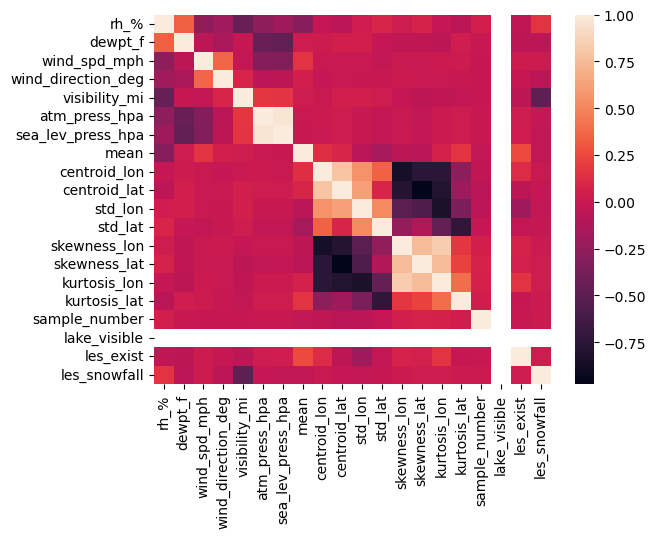

In [13]:
corr = combined_df.corr()
sns.heatmap(combined_df.corr(), xticklabels=corr.columns.values, yticklabels=corr.columns.values )

Let's have a look at covariance as well

<AxesSubplot:>

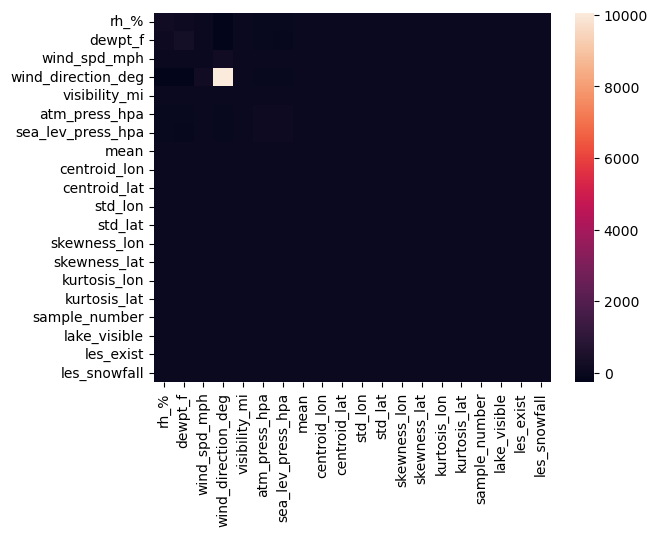

In [14]:
covar = combined_df.cov()
sns.heatmap(covar, xticklabels=covar.columns.values, yticklabels=covar.columns.values)

Pair plotting the features

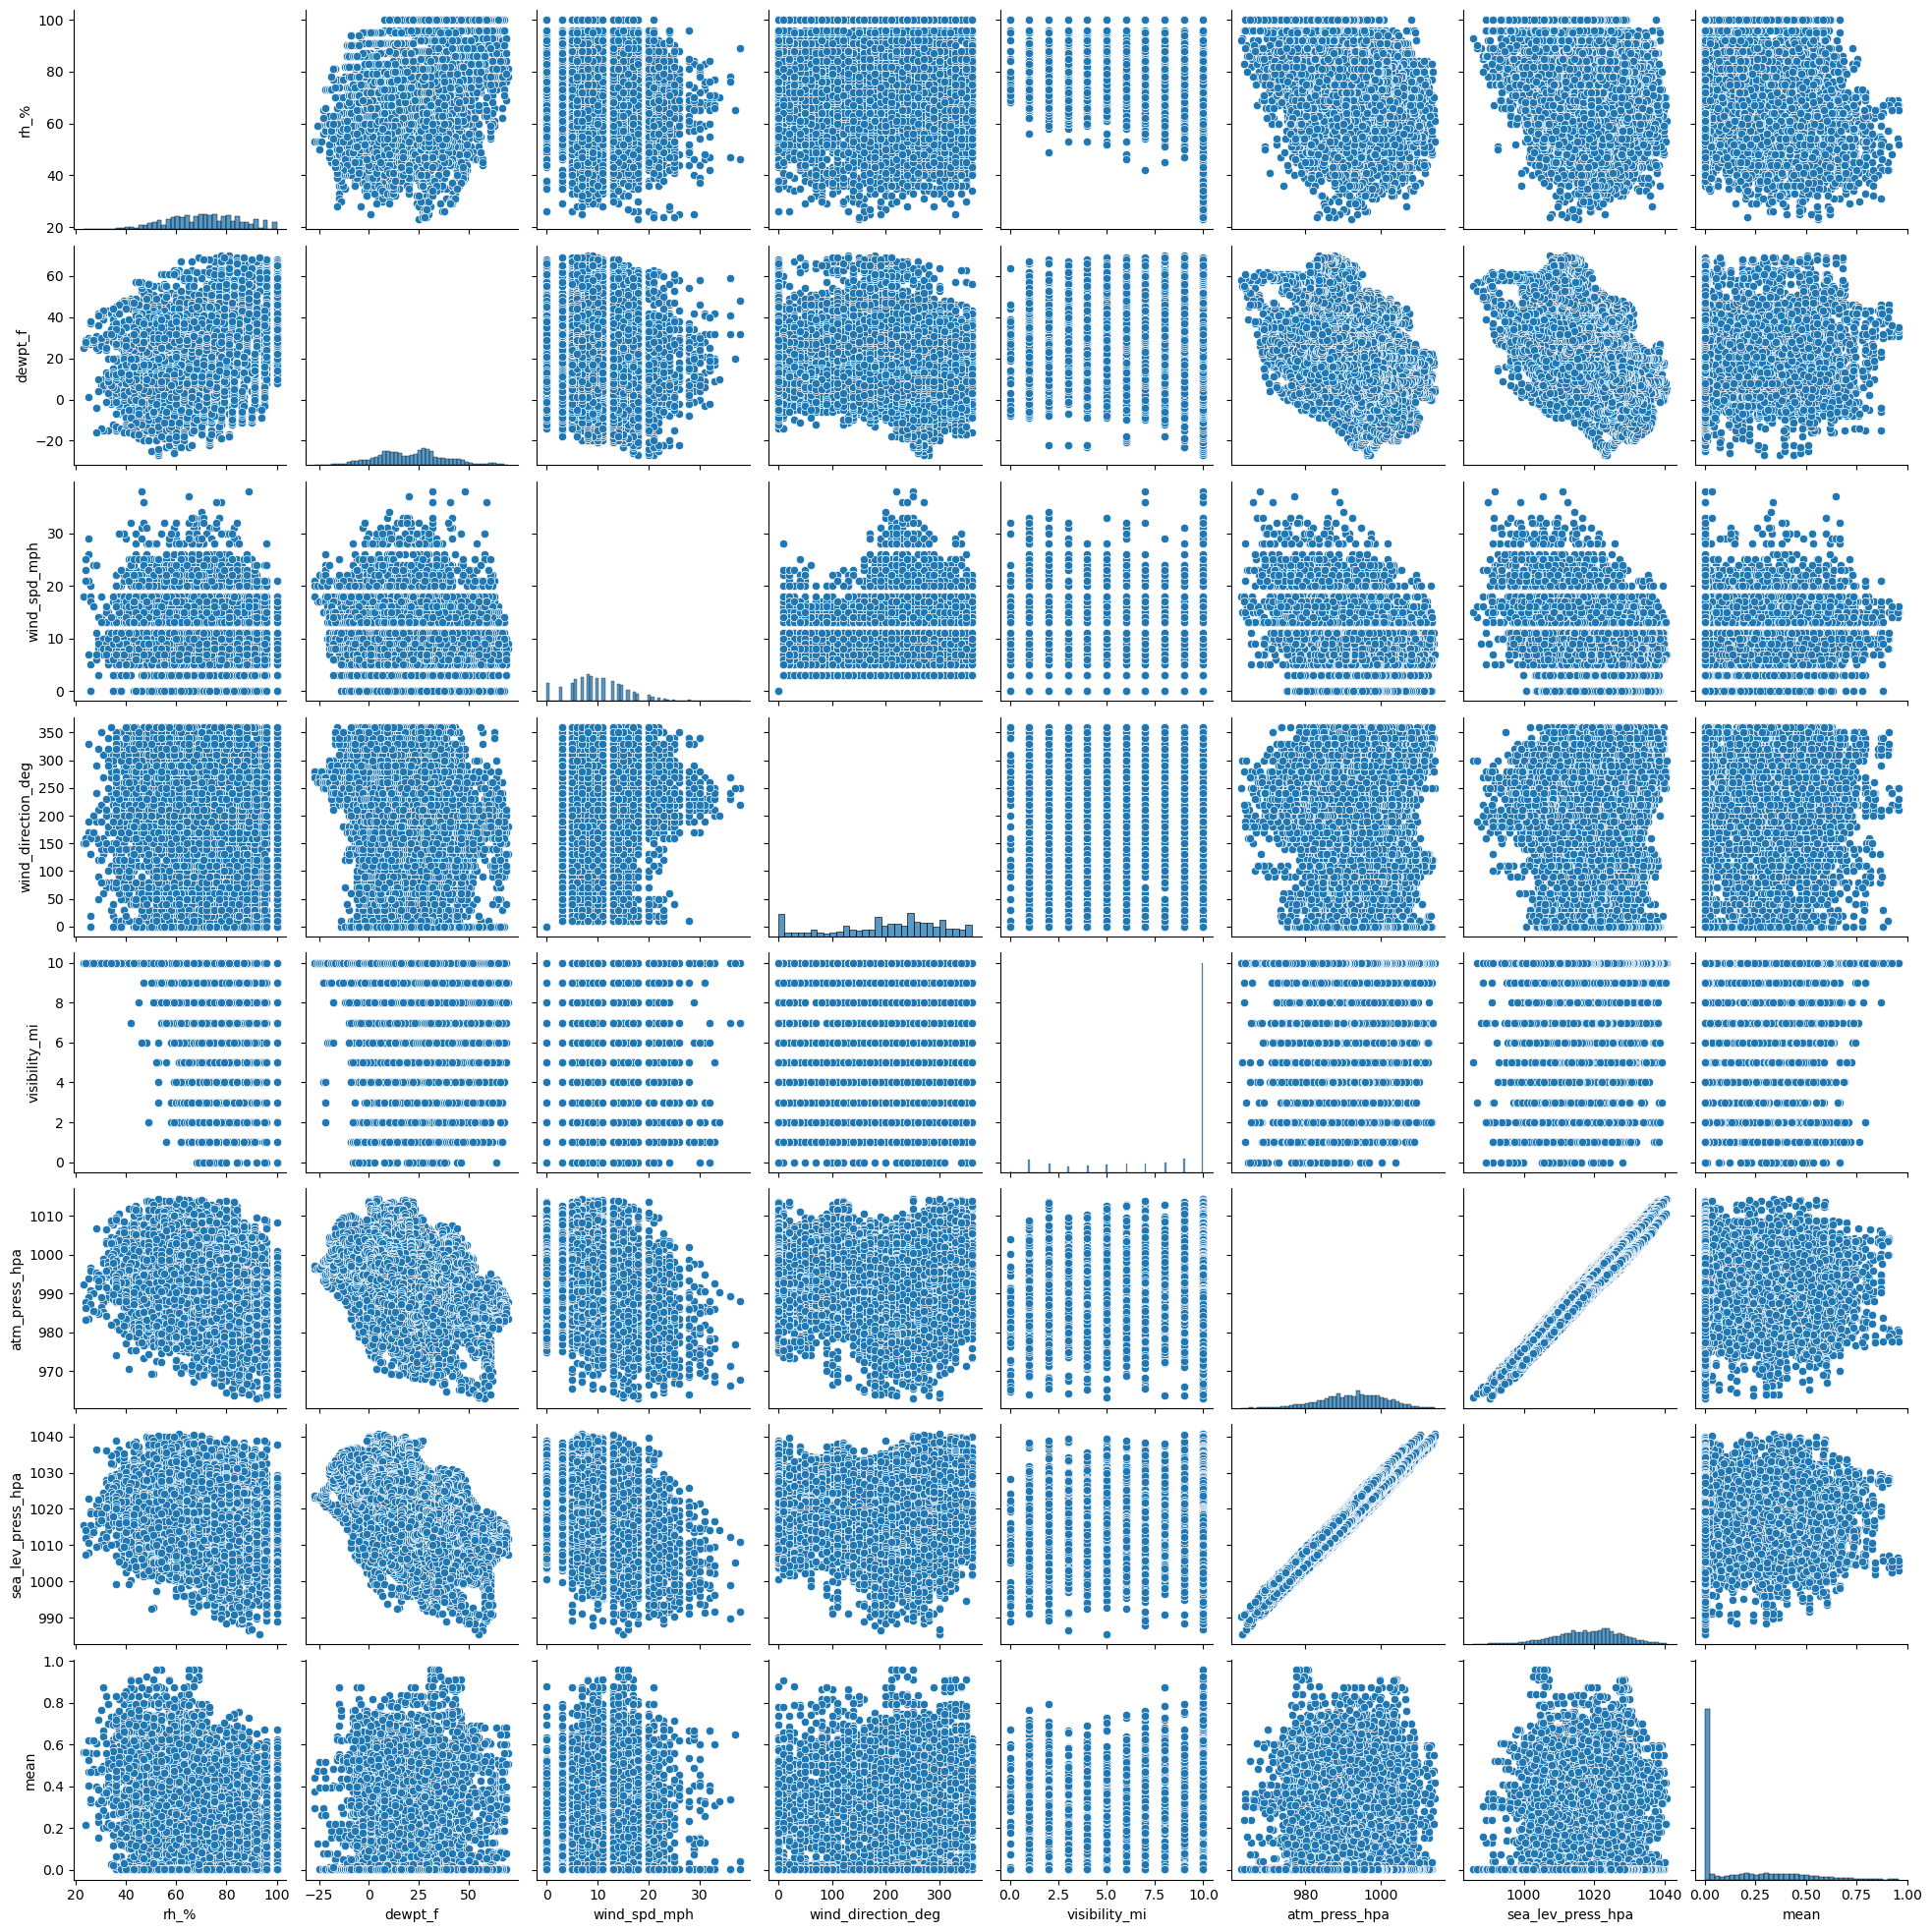

In [15]:
sns.pairplot(combined_df[['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg','visibility_mi', 'atm_press_hpa',
       'sea_lev_press_hpa', 'mean']])

We can see that `atm_press_hpa` and `sea_lev_press_hpa` are linearly correlated.

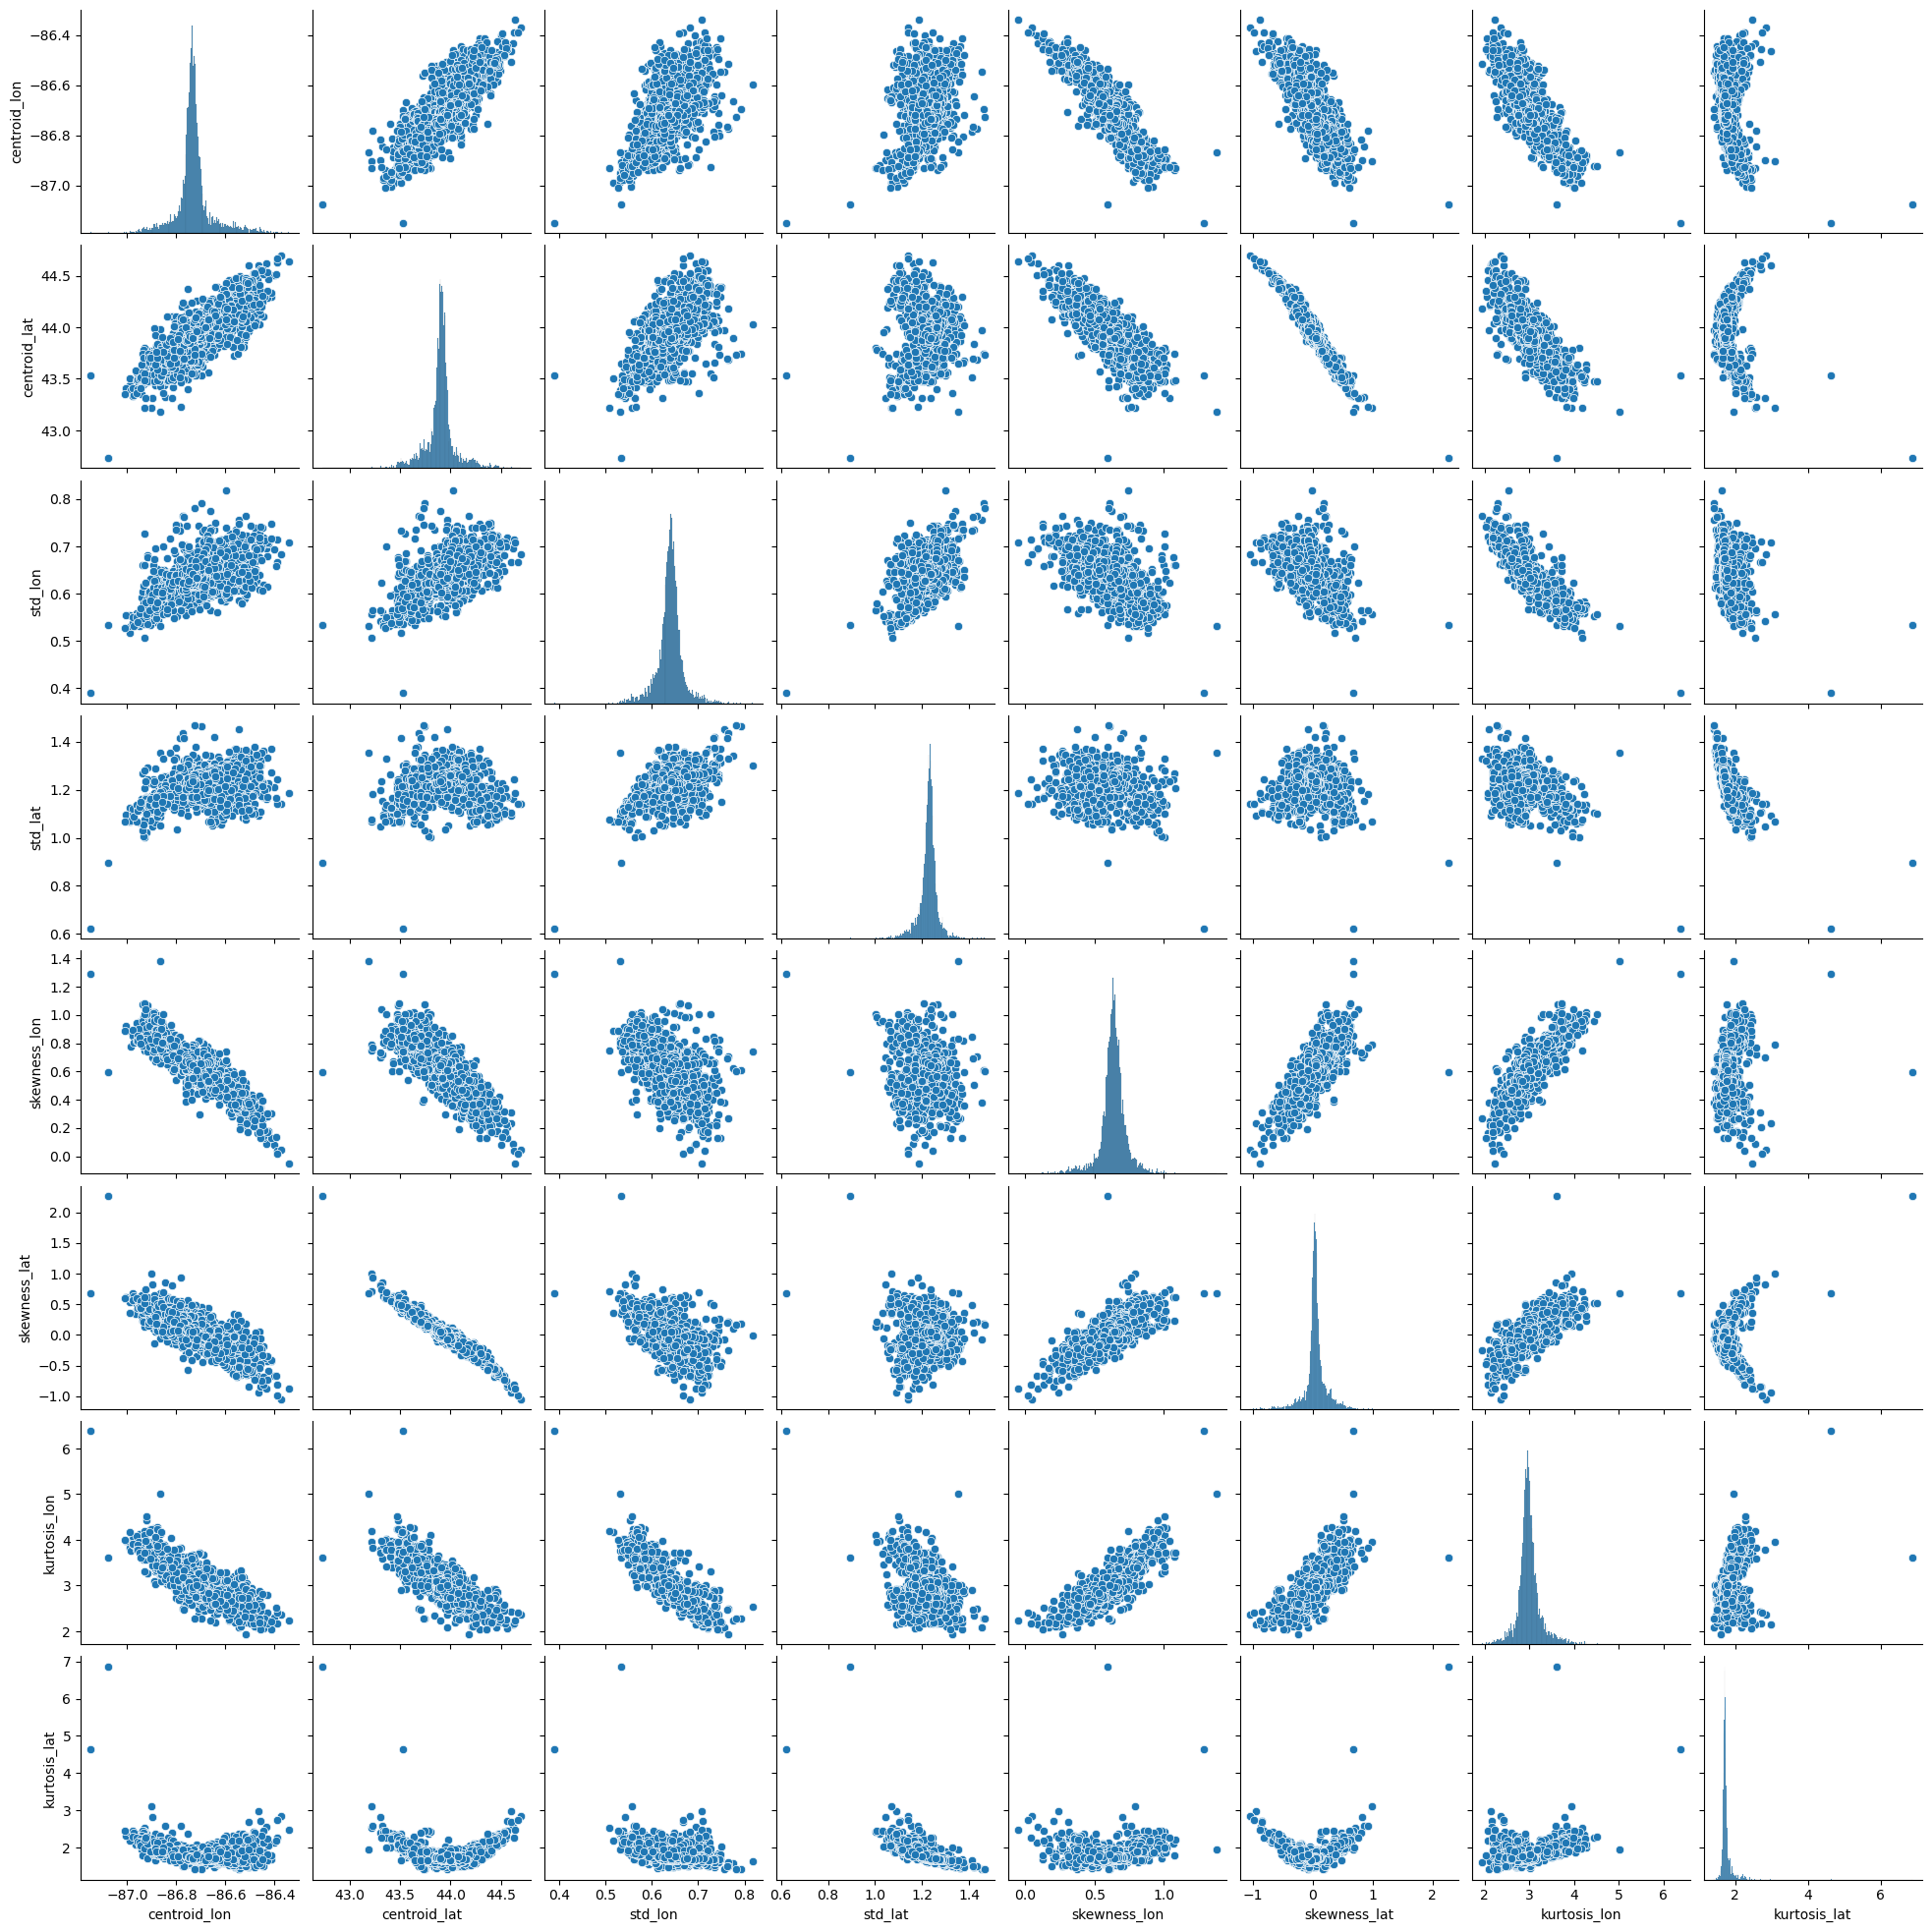

In [16]:
sns.pairplot(combined_df[['centroid_lon',
       'centroid_lat', 'std_lon', 'std_lat', 'skewness_lon', 'skewness_lat',
       'kurtosis_lon', 'kurtosis_lat']])

From here we can see that `skewness_lat` and `centroid_lat` are linearly correlated.
So we can keep either one these features.

So, we. will drop `sea_lev_press_hpa` and `skewness_lat` columns from the dataset

In [17]:
combined_df = combined_df.drop(['sea_lev_press_hpa', 'skewness_lat'], axis=1)
combined_df = combined_df.reset_index(drop=True)

## Shifting the dataframe

As we want to predict the snowfall some days in advance, we will shift the target column.

In [18]:
def shift_col(data, hours):
    data3 = data.copy()
    data3['les_snowfall'] = data.les_snowfall.shift(-hours)
    data3 = data3.dropna()
    data3 = data3.reset_index(drop=True)
    return data3

Shifting the target column by 3 days i.e 72 hours

In [19]:
shifted_df = shift_col(combined_df,72)
print(shifted_df.shape)
shifted_df.tail()

(6792, 18)


,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,mean,centroid_lon,centroid_lat,std_lon,std_lat,skewness_lon,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
6787,82,47,25,200,10,971.4,0.002031,-86.733186,43.892129,0.645161,1.202671,0.633739,2.913511,1.756154,3.0,0.0,0,0.0
6788,82,47,22,210,10,971.7,0.002189,-86.729769,43.871569,0.660108,1.263018,0.669346,2.966865,1.701110,4.0,0.0,0,0.0
6789,82,41,22,240,10,973.0,0.002417,-86.758260,43.871664,0.626284,1.234722,0.605627,2.946596,1.726023,4.0,0.0,0,0.0
6790,82,38,25,240,10,974.7,0.002089,-86.702067,43.942192,0.644551,1.240941,0.513491,2.779638,1.650768,3.0,0.0,0,0.0
6791,100,39,18,240,4,977.3,0.002664,-86.703657,43.944770,0.642032,1.229564,0.560725,2.802304,1.718199,4.0,0.0,0,0.0


In [20]:
from collections import Counter
cnt = Counter(shifted_df['les_snowfall'])
cnt

Counter({0.0: 6450, 1.0: 342})

This is a clear indication of baised data, as there are many samples with zero as compared to one. In order for a decision tree to make accurate prediction, it should have equal number of positive and negative samples. <br>
Hence we will use weighted SVC from sklearn to try to get a prediction closer to accurate.

## Splitting into train and test dataset

In [21]:
shifted_df.columns

Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'atm_press_hpa', 'mean', 'centroid_lon',
       'centroid_lat', 'std_lon', 'std_lat', 'skewness_lon', 'kurtosis_lon',
       'kurtosis_lat', 'sample_number', 'lake_visible', 'les_exist',
       'les_snowfall'],
      dtype='object')

In [22]:
X_dev = ['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'atm_press_hpa', 'mean', 'centroid_lon',
       'centroid_lat', 'std_lon', 'std_lat', 'skewness_lon', 'kurtosis_lon',
       'kurtosis_lat', 'sample_number', 'lake_visible', 'les_exist']

In [23]:
X = pd.DataFrame(shifted_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = shifted_df['les_snowfall']
print("Dependant variable : les_snowfall")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'atm_press_hpa', 'mean', 'centroid_lon',
       'centroid_lat', 'std_lon', 'std_lat', 'skewness_lon', 'kurtosis_lon',
       'kurtosis_lat', 'sample_number', 'lake_visible', 'les_exist'],
      dtype='object')
Dependant variable : les_snowfall


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [25]:
cnt = Counter(y_train)
cnt

Counter({0.0: 5155, 1.0: 278})

In [26]:
cnt = Counter(y_test)
cnt

Counter({0.0: 1295, 1.0: 64})

## Hyperparameter tuning with sklearn
Using PCA and a radial basis function (rbf) sklearn SVC.

In [32]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=15, whiten=True, random_state=42)
#pca = RandomizedPCA(n_components=20, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Shape of Training Dataset

In [33]:
X_train.shape, y_train.shape

((5433, 17), (5433,))

Shape of Testing Dataset

In [34]:
X_test.shape, y_test.shape

((1359, 17), (1359,))

We will first predict the hyperparameters on first 1000 observations of the train dataset. 

In [35]:
X_train_reduced = X_train[:1000]
y_train_reduced = y_train[:1000]

Shape of the reduced data

In [36]:
X_train_reduced.shape, y_train_reduced.shape

((1000, 17), (1000,))

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [0.5, 1, 5, 10, 50, 100],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train_reduced, y_train_reduced)
print(grid.best_params_)

CPU times: user 43.3 s, sys: 21.4 s, total: 1min 4s
Wall time: 8.14 s
{'svc__C': 50, 'svc__gamma': 0.1}


Here we're getting optimal values of hyperparameters svc_C = 50 & svc_gamma = 0.1

Slicing dataset to get 5000 observations

In [39]:
X_train_reduced = X_train[:5000]
y_train_reduced = y_train[:5000]

Shape of training dataset

In [40]:
X_train_reduced.shape, y_train_reduced.shape

((5000, 17), (5000,))

Below we are training the model with more values of C and gamma parameters.<br>
**Note: You can skip this step while re running the notebook**

In [44]:

param_grid = {'svc__C': [20,40,50,75],
              'svc__gamma': [0.05, 0.1, 0.5]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train_reduced, y_train_reduced)
print(grid.best_params_)
model = grid.best_estimator_

CPU times: user 2min 4s, sys: 52 s, total: 2min 56s
Wall time: 40.9 s
{'svc__C': 20, 'svc__gamma': 0.5}


Below we are dumping the model into a pickle file

In [51]:
#
# with open('model_pkl', 'wb') as files:
#     pickle.dump(model, files)

Loading the model from pickle file:

In [45]:
with open('model_pkl' , 'rb') as f:
    model = pickle.load(f)

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen.
Slicing 1000 observations for testing.

In [46]:
X_test_reduced = X_test[:1000]
y_test_reduced = y_test[:1000]

Shape of testing dataset

In [47]:
X_test_reduced.shape, y_test_reduced.shape

((1000, 17), (1000,))

Now we will fit the model on our test data

In [48]:
y_fit = model.predict(X_test_reduced)

## Classification Report

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test_reduced, y_fit))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       947
         1.0       0.07      0.02      0.03        53

    accuracy                           0.94      1000
   macro avg       0.51      0.50      0.50      1000
weighted avg       0.90      0.94      0.92      1000



## Confusion Matrix 

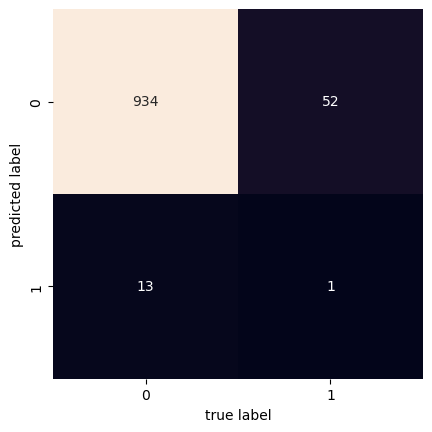

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test_reduced, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Conclusion

Here we're getting an accuracy of 94% after using SVM on the LES dataset which is almost same the as we got in the Decision Tree model.